# Predicting FaceMask Wearing

Data source: masks_dataset.pickle

Predicting: {0: 'No mask', 1: 'Mask', 2: 'Incorrect'}

## 1. Prepare environment

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from environment import prepare_environment

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision.transforms import v2
from torchmetrics import Accuracy

In [2]:
# Global variables
SEED = 42

In [3]:
# Check if your GPU driver and CUDA is enabled and accessible by PyTorch
torch.cuda.is_available()

True

In [4]:
# Environment configuration
torch.set_printoptions(precision=10)
np.random.seed(SEED)

prepare_environment()

## 2. Read dataset

In [5]:
# Reading dataset
features, labels = pd.read_pickle('data-sources/masks_dataset.pickle')

# Reshaping the images set to have the channel in the second dimension
features = np.transpose(features, (0, 3, 1, 2))

# Encoding the target variable
labels = F.one_hot(torch.tensor(labels), num_classes=len(set(labels)))

print(f"""
Features: {features.shape} = {np.prod(features.shape[1:])}
Target  : {labels.shape} = {np.prod(labels.shape[1:])}
""")


Features: (355, 3, 32, 32) = 3072
Target  : torch.Size([355, 3]) = 3



## 3. Split into train, valid and test

In [6]:
# Instantiate dataset class
dataset = TensorDataset(torch.tensor(features).float(), labels.float())

# Splitting into training, validation and testing set
set_train, set_val = random_split(dataset, [.8, .2])
set_val, set_test = random_split(set_val, [.5, .5])

len(set_train), len(set_val), len(set_test)

(284, 36, 35)

In [7]:
# Creating dataloaders
loader_train = DataLoader(set_train, batch_size=500, shuffle=True)
loader_val = DataLoader(set_val, batch_size=500, shuffle=True)
loader_test = DataLoader(set_test, batch_size=500, shuffle=True)

len(loader_train), len(loader_val), len(loader_test)  # Just one batch created

(1, 1, 1)

## 4. Build the model

In [8]:
# Getting mean and std per channel in images:
mean = np.mean(features, axis=(0, 2, 3))
std = np.std(features, axis=(0, 2, 3))

# Create multi classification model
model = nn.Sequential(
    v2.Normalize(mean=mean, std=std),
    nn.Flatten(),
    nn.Linear(3072, 3),
    nn.Softmax(dim=-1)  # Softmax activation
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.95)

# Create accuracy metric
accuracy = Accuracy(task="multiclass", num_classes=3)

## 5. Train on the training set

In [9]:
# Set the model to training mode
model.train()

# Loop through the dataset multiple times
losses = []
epochs = int(1e3)
for epoch in range(epochs):
    for data in loader_train:
        X, y = data                                # Get feature and target from the data loader
        optimizer.zero_grad()                      # zero the parameter gradients
        y_pred = model(X)                          # Run a forward pass
        loss = criterion(y_pred, y)                # Compute loss 
        loss.backward()                            # Backward pass
        optimizer.step()                           # Optimization
        acc = accuracy(y_pred, y.argmax(dim=-1))   # Calculate accuracy
    
    losses.append(loss.item())         # Record the loss per epoch
    if (epoch + 1) % 100 == 0:         # Print the loss every 100 epochs
        print(f'Epoch [{epoch+1}], Loss: {loss.item():.4f}')

training_loss = loss
training_acc = accuracy.compute()
print(f"Training Accuracy: {training_acc}")

# Reset the metric for next evaluation 
accuracy.reset()

Epoch [100], Loss: 0.6897
Epoch [200], Loss: 0.6256
Epoch [300], Loss: 0.6049
Epoch [400], Loss: 0.5967
Epoch [500], Loss: 0.5922
Epoch [600], Loss: 0.5892
Epoch [700], Loss: 0.5872
Epoch [800], Loss: 0.5857
Epoch [900], Loss: 0.5845
Epoch [1000], Loss: 0.5836
Training Accuracy: 0.9507429599761963


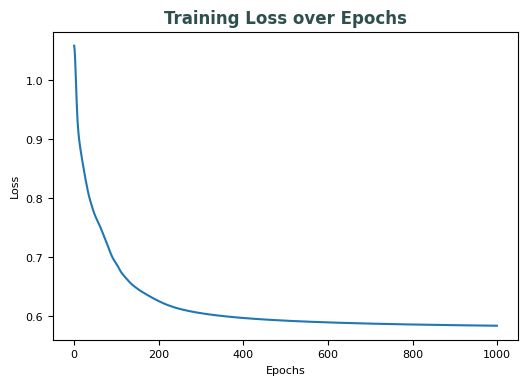

In [10]:
# Visualizing the loss data in training set
fig = plt.figure(figsize=(6,4))
plt.plot(range(epochs), losses)
plt.title("Training Loss over Epochs")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## 6. Evaluate model

In [11]:
# Set the model to evaluation mode
model.eval()

# Iterating over validation dataloader
with torch.no_grad():
    for data in loader_val:
        X, y = data                                # Get feature and target from the data loader
        y_pred = model(X)                          # Get predictions
        loss = criterion(y_pred, y)                # Calculate the loss
        acc = accuracy(y_pred, y.argmax(dim=-1))   # Calculate accuracy
        
acc = accuracy.compute()

# Calculate the mean loss value
print(f'Training   Set: Loss >> {training_loss}, Accuracy >> {training_acc}')
print(f'Validation Set: Loss >> {loss}, Accuracy >> {acc}')

# Reset the metric for next evaluation 
accuracy.reset()

Training   Set: Loss >> 0.58357834815979, Accuracy >> 0.9507429599761963
Validation Set: Loss >> 0.7093584537506104, Accuracy >> 0.8333333134651184


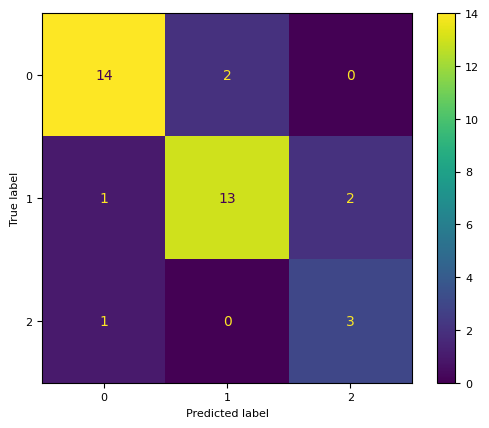

In [12]:
cm = confusion_matrix(y.argmax(dim=-1).numpy().flatten(), 
                      y_pred.argmax(dim=-1).numpy().flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [13]:
pd.DataFrame({
    'y_true': y.argmax(dim=-1).numpy().flatten(),
    'y_pred': y_pred.argmax(dim=-1).numpy().flatten(),
    'Accerted': ['True' 
                 if y[i].argmax(dim=-1).numpy().flatten() == y_pred[i].argmax(dim=-1).numpy().flatten()
                 else ''
                 for i in range(len(y))] 
})

,y_true,y_pred,Accerted
0,0,0,True
1,1,1,True
2,1,1,True
3,2,2,True
4,2,2,True
5,0,0,True
6,1,1,True
7,0,0,True
8,1,1,True
9,0,0,True


----------------------------------